In [1]:
import pickle
import numpy as np

In [2]:
data_path = '/home/maybe/MOT17/train/MOT17-02-DPM/'

In [3]:
from os import path
from glob import glob
from collections import defaultdict

In [4]:
seqs = defaultdict(dict)
objs = defaultdict(dict)
with open(path.join(data_path, 'gt', 'gt.txt')) as f:
    for seq, obj, *data in [line.strip().split(',') for line in f.readlines()]:
        if int(obj) < 16:
            seqs[int(seq)][int(obj)] = data
            objs[int(obj)][int(seq)] = data

In [5]:
pb = defaultdict(dict)
for file in glob('../results_*.p'):
    obj_id = int(file.split('_')[1].split('.')[0])
    with open(file, 'rb') as f:
        r = pickle.load(f)
    pb[obj_id] = r

In [8]:
rb = defaultdict(dict)
for obj, values in objs.items():
    for v, d in values.items():
        if v < len(r[obj]):
            rb[v][obj] = pb[obj][v]

## Metrics

In [9]:
def location(rect1, rect2):
    cx1, cy1 = rect1[0] + rect1[2]/2, rect1[1] + rect1[3]/2
    cx2, cy2 = rect2[0] + rect2[2]/2, rect2[1] + rect2[3]/2
    return ((cy2-cy1)**2 + (cx2-cx1)**2)**.5

In [10]:
def overlap(rect1, rect2):
    left = np.maximum(np.maximum(0, rect1[0]), np.maximum(0, rect2[0]))
    right = np.minimum(rect1[0] + rect1[2], rect2[0] + rect2[2])
    top = np.maximum(np.maximum(0, rect1[1]), np.maximum(0, rect2[1]))
    bottom = np.minimum(rect1[1] + rect1[3], rect2[1] + rect2[3])
    intersect = np.maximum(0, right - left) * np.maximum(0, bottom - top)
    intersect = 0 if intersect < 0 else intersect
    union = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersect
    iou = np.clip(intersect / union, 0, 1)
    return iou

In [11]:
import matplotlib.pyplot as plt

In [12]:
for seq, oo in rb.items():
    if not seq: continue

In [44]:
iou = np.asarray([overlap(np.array(list(map(float, gbox[:4]))), bbox[:4]) for seq, oo in rb.items() for gbox, bbox in zip(seqs[seq].values(), oo.values())])

In [45]:
x_iou = np.arange(0, 1.01, .01)

In [46]:
perf_iou = [iou[np.where(iou>=flag)].size / iou.size for flag in x_iou]

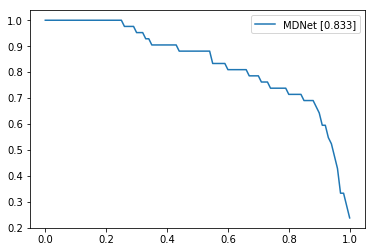

In [47]:
plt.plot(x_iou, perf_iou, label='MDNet [%.3f]' % (sum(perf_iou) / len(perf_iou)))
plt.legend()
plt.show()

In [17]:
cle = np.asarray([location(list(map(float, gbox[:4])), bbox[:4]) for seq, oo in rb.items() for gbox, bbox in zip(seqs[seq].values(), oo.values())])

In [18]:
x_cle = np.arange(0, 50, .1)

In [19]:
perf_cle = [cle[np.where(cle<=flag)].size / cle.size for flag in x_cle]

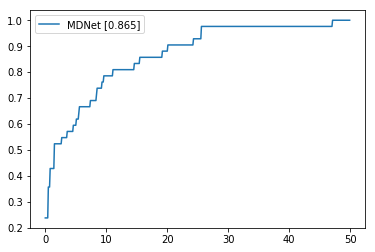

In [20]:
plt.plot(x_cle, perf_cle, label='MDNet [%.3f]' % (sum(perf_cle) / len(perf_cle)))
plt.legend()
plt.show()

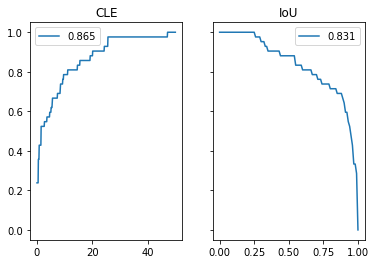

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x_cle, perf_cle, label='%.3f' % (sum(perf_cle) / len(perf_cle)))
ax1.set_title('CLE')
ax1.legend()
ax2.plot(x_iou, perf_iou, label='%.3f' % (sum(perf_iou) / len(perf_iou)))
ax2.set_title('IoU')
ax2.legend()

## Previews

In [22]:
from PIL import Image, ImageDraw
from IPython.display import display

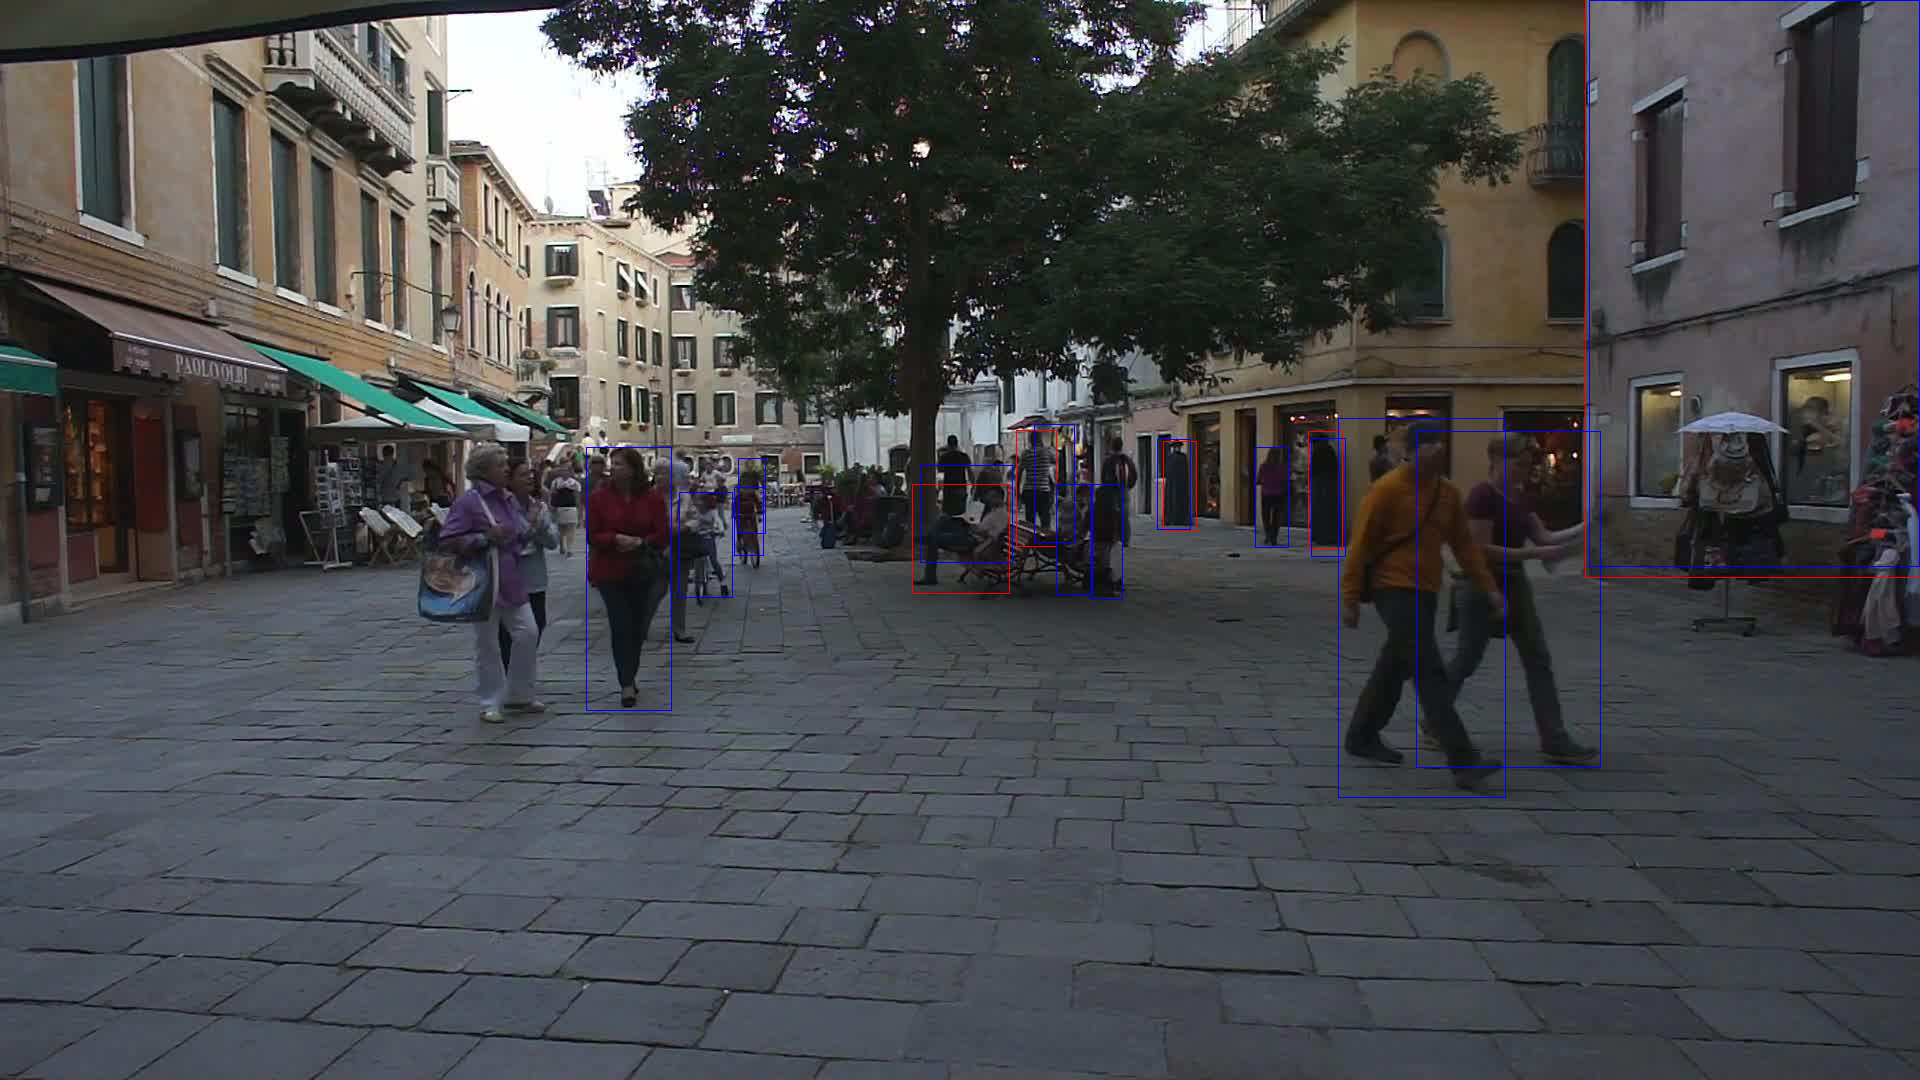

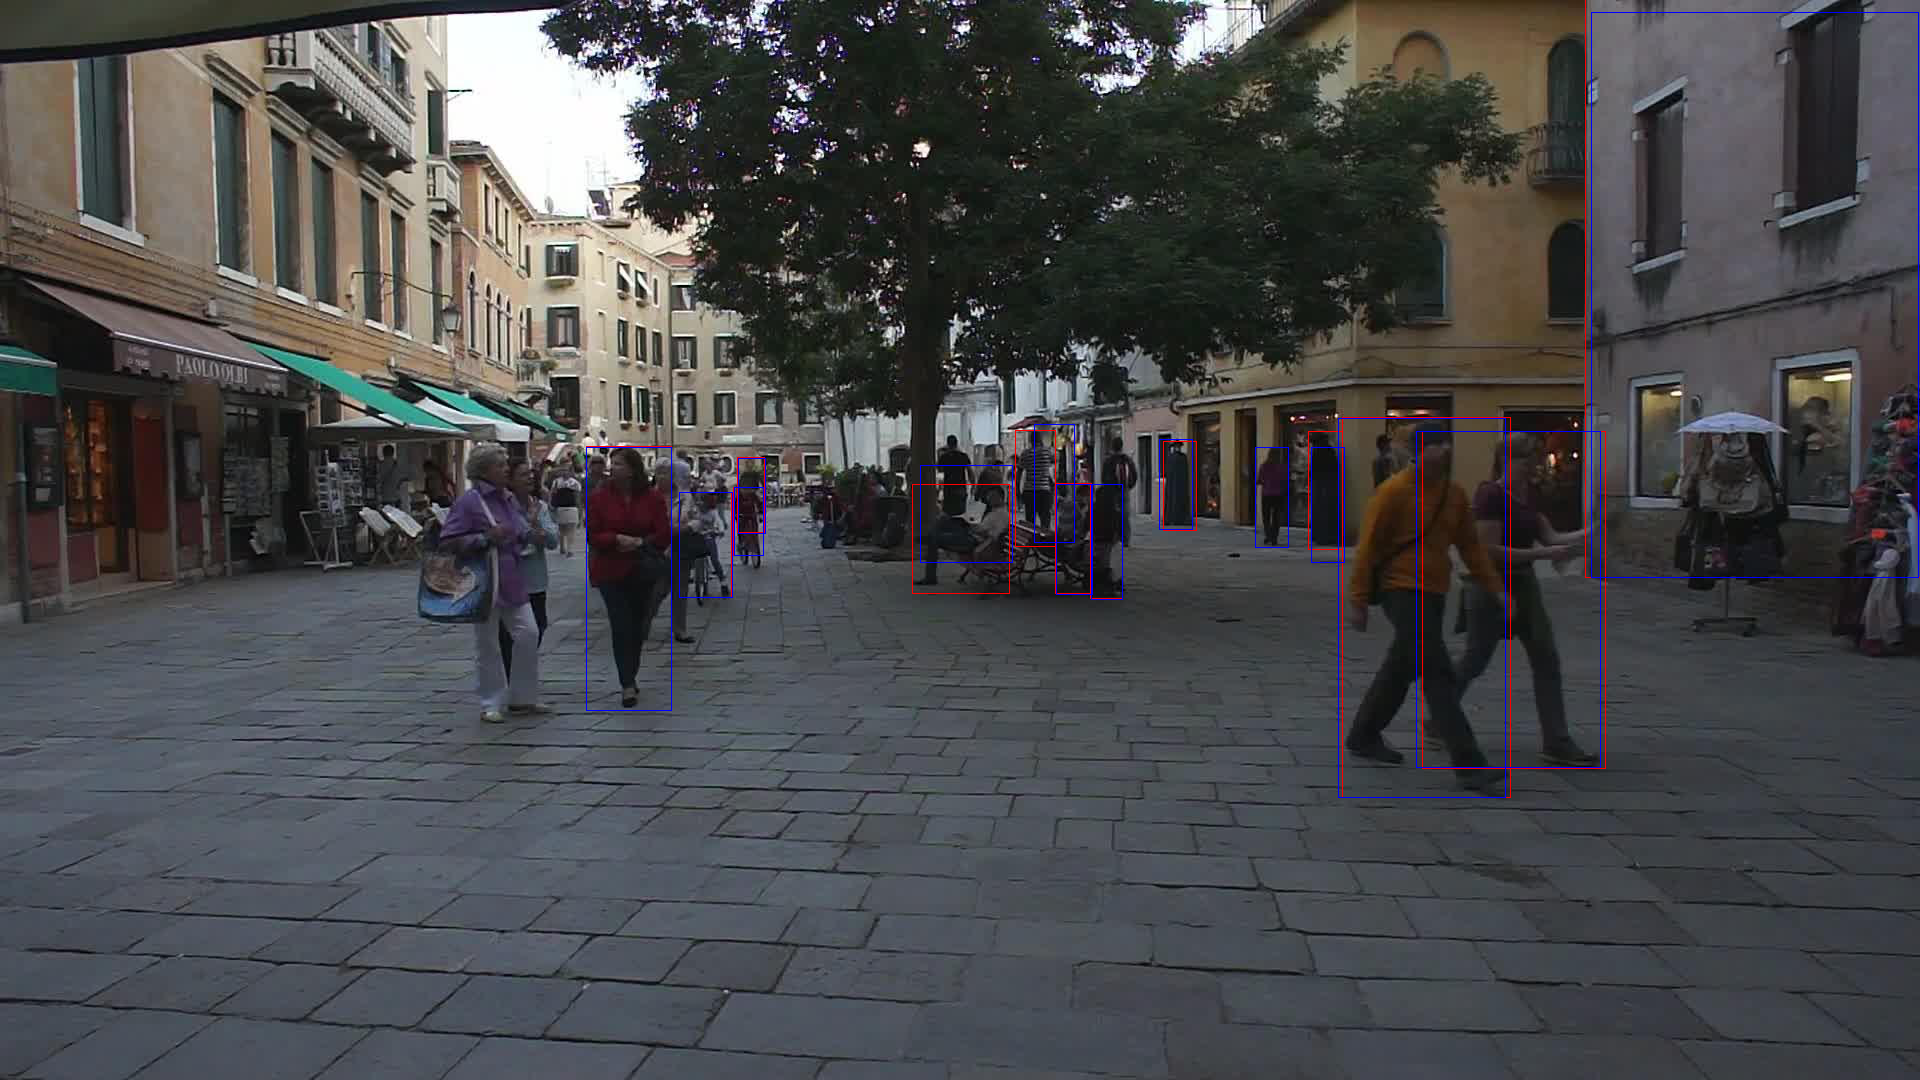

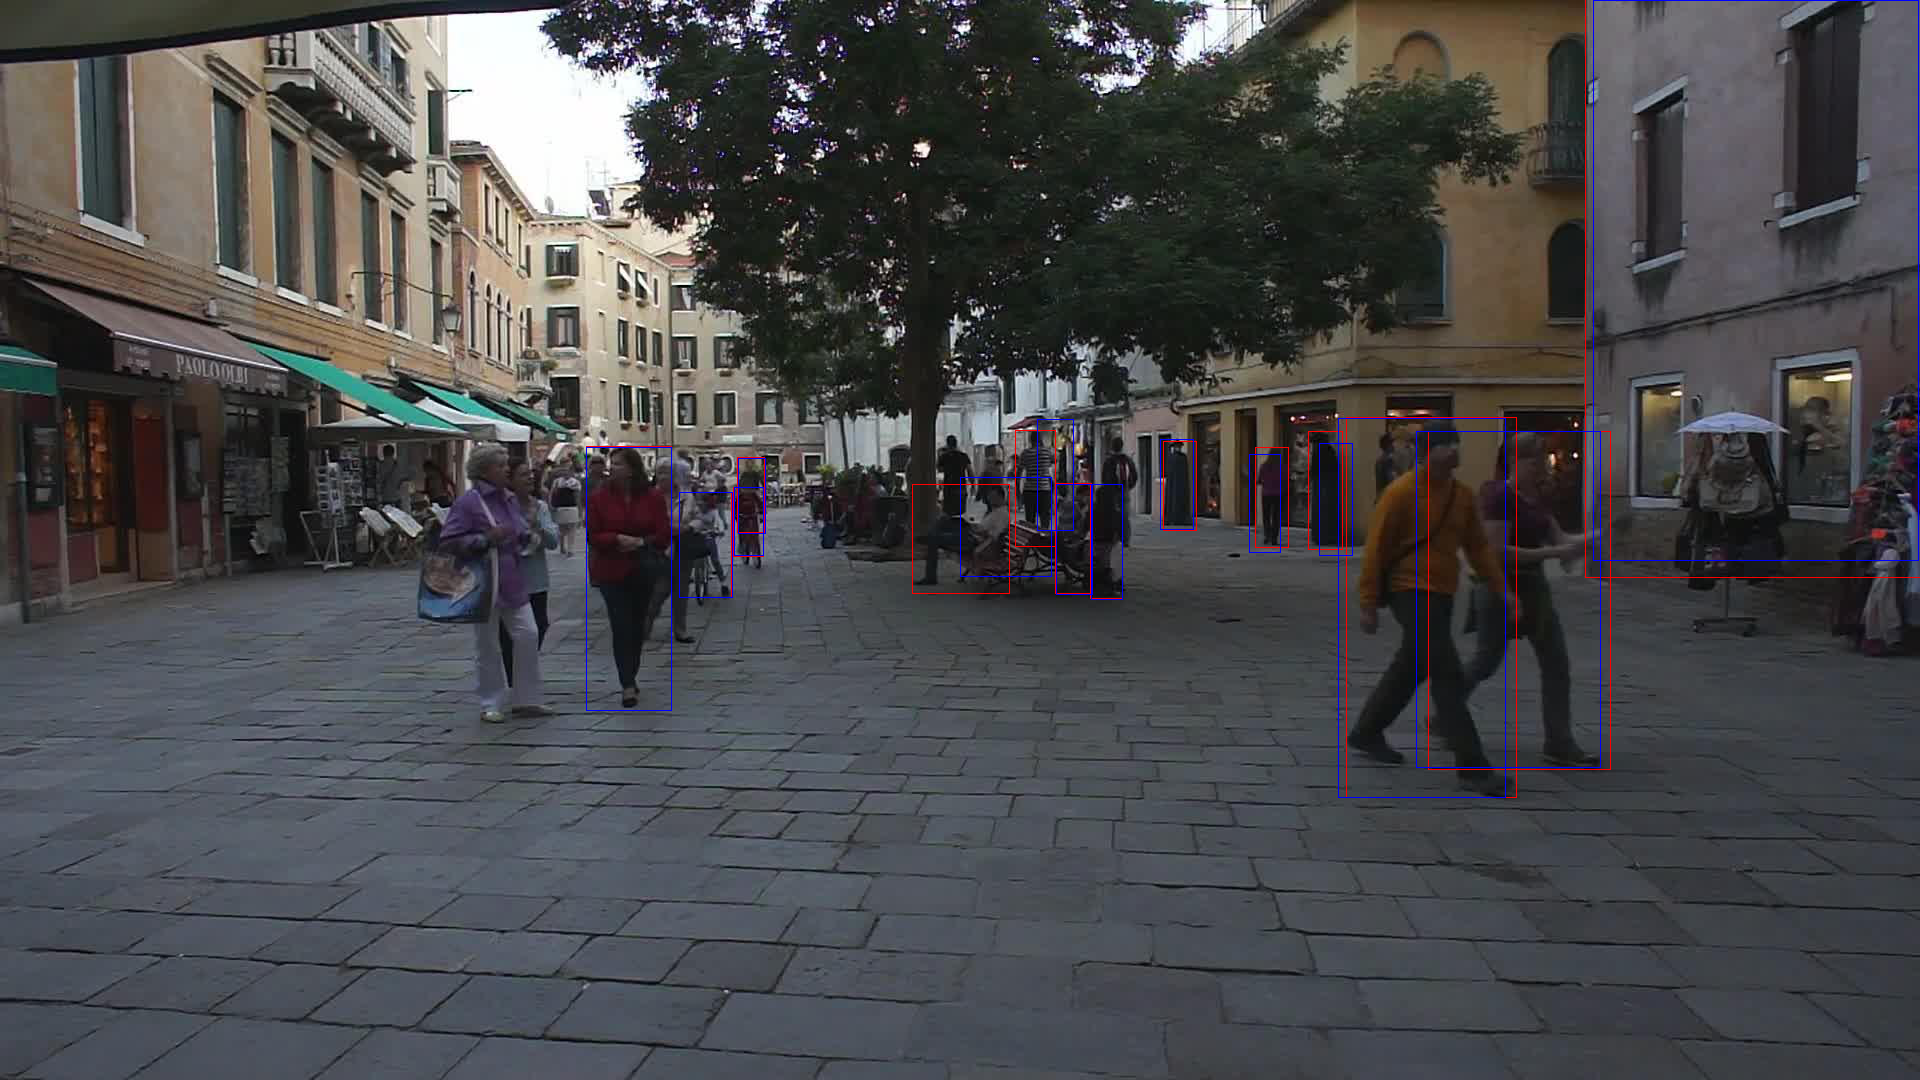

In [23]:
for seq, oo in rb.items():
    if not seq: continue
    ig = Image.open(path.join(data_path, 'img1', '%06d.jpg' % (seq)))
    dr = ImageDraw.Draw(ig)
    for o, value in seqs[seq].items():
        x, y, w, h, *_ = map(float, value)
        dr.rectangle(((x, y), (x+w, y+h)), outline="red")
    for o, value in oo.items():
        x, y, w, h, *_ = map(float, value)
        dr.rectangle(((x, y), (x+w, y+h)), outline="blue")
    display(ig)